In [ ]:
from google.colab import files
from PIL import Image
import io
from IPython.display import display
import numpy as np

def rotate_and_show_image():
    # Upload the image from your local drive
    uploaded = files.upload()
    file_name = next(iter(uploaded.keys()))

    # Open the image file
    image = Image.open(io.BytesIO(uploaded[file_name]))

    # Get the dimensions of the original image
    width, height = image.size

    # Original image corners
    v1, w1 = (0, 0)
    v2, w2 = (width, 0)
    v3, w3 = (0, height)
    v4, w4 = (width, height)

    # Ask for the rotation angle
    angle = float(input("Enter the rotation angle (in degrees): "))

    # Rotate the image and expand the edges to ensure the entire rotated image fits in the canvas
    rotated_image = image.rotate(angle, resample=Image.BICUBIC, expand=True)

    # Display the rotated image
    display(rotated_image)

    # Calculating the new corners after rotation involves some trigonometry
    rad_angle = np.deg2rad(angle)  # Convert angle to radians
    cos_angle = np.cos(rad_angle)
    sin_angle = np.sin(rad_angle)

    # The rotation matrix for 2D rotation
    rotation_matrix = np.array([
        [cos_angle, -sin_angle],
        [sin_angle, cos_angle]
    ])

    # Center of the original image
    cx, cy = width / 2, height / 2

    # Corners relative to the center point
    corners = np.array([
        [-cx, -cy],
        [cx, -cy],
        [-cx, cy],
        [cx, cy]
    ])

    # Calculate the new corner positions
    new_corners = np.dot(corners, rotation_matrix.T)

    # Since the image size often changes, we need the new image center
    new_cx, new_cy = rotated_image.size[0] / 2, rotated_image.size[1] / 2

    # Translate the corners back relative to the top-left corner
    translated_corners = new_corners + [new_cx, new_cy]
    translated_corners = new_corners

    # Extracting individual coordinates for clarity
    (x1, y1), (x2, y2), (x3, y3), (x4, y4) = translated_corners

    # Print the coordinates before and after rotation
    print(f"Original image corners:\n(v1, w1): ({v1}, {w1})\n(v2, w2): ({v2}, {w2})\n(v3, w3): ({v3}, {w3})\n(v4, w4): ({v4}, {w4})")
    print(f"\nRotated image corners:\n(x1, y1): ({x1}, {y1})\n(x2, y2): ({x2}, {y2})\n(x3, y3): ({x3}, {y3})\n(x4, y4): ({x4}, {y4})")

    # Save the rotated image in memory
    buffer = io.BytesIO()
    rotated_image.save(buffer, format='PNG')

    return rotated_image, corners, translated_corners, image

Saving pgu.jpg to pgu.jpg
Enter the rotation angle (in degrees): 30


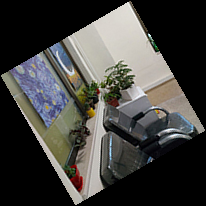

Original image corners:
(v1, w1): (0, 0)
(v2, w2): (150, 0)
(v3, w3): (0, 150)
(v4, w4): (150, 150)

Rotated image corners:
(x1, y1): (-27.451905283832904, -102.4519052838329)
(x2, y2): (102.4519052838329, -27.45190528383291)
(x3, y3): (-102.4519052838329, 27.45190528383291)
(x4, y4): (27.451905283832904, 102.4519052838329)
Coefficients:
c1: 0.8660254037844387, c2: -0.5000000000000002, c3: -1.2931652005731403e-17, c4: 4.852234364790809e-15, c5: 0.4999999999999994, c6: 0.8660254037844385, c7: 8.90454635457414e-18, c8: 9.190094269621245e-14

Residuals: []


In [ ]:
import numpy as np

def calculate_transformation_coefficients():
    # Get the necessary data from the rotate_and_show_image function
    rotated_image, original_corners, rotated_corners, image = rotate_and_show_image()

    # original_corners are in the form [[v1, w1], [v2, w2], [v3, w3], [v4, w4]]
    # rotated_corners are in the form [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]

    # Prepare the matrices for the linear system
    A = []
    b = []

    for (v, w), (x, y) in zip(original_corners, rotated_corners):
        # Equations for x
        A.append([v, w, v * w, 1, 0, 0, 0, 0])
        b.append(x)

        # Equations for y
        A.append([0, 0, 0, 0, v, w, v * w, 1])
        b.append(y)

    # Convert A to a 2D array and b to a 1D array for the linear solver
    A = np.array(A)
    b = np.array(b)

    # Solve the linear system
    coefficients, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

    # Extracting the coefficients
    c1, c2, c3, c4, c5, c6, c7, c8 = coefficients

    # You might want to print or return the coefficients and residuals
    print("Coefficients:")
    print(f"c1: {c1}, c2: {c2}, c3: {c3}, c4: {c4}, c5: {c5}, c6: {c6}, c7: {c7}, c8: {c8}")
    print("\nResiduals:", residuals)

    return rotated_image, original_corners, rotated_corners, image, coefficients

# Now call your new function to perform the calculation
rotated_image, original_corners, rotated_corners, image, coefficients = calculate_transformation_coefficients()


In [ ]:
from PIL import Image
import numpy as np

def reverse_transform(rotated_image, coefficients, image):
    import cv2
    c1, c2, c3, c4, c5, c6, c7, c8 = coefficients

    # Dimensions of the original image
    if isinstance(rotated_image, Image.Image):
      image = np.array(image)

    original_height, original_width, _ = image.shape

    # Create an empty array to hold the new image
    original_image_array = np.zeros((original_height, original_width, 3), dtype=np.uint8)

    # Convert the rotated image to an array if it's not
    if isinstance(rotated_image, Image.Image):
        rotated_image = np.array(rotated_image)

    rotated_height, rotated_width, _ = rotated_image.shape


    # Calculate the original center
    original_center_x = original_width / 2
    original_center_y = original_height / 2

    # Use the coefficients to calculate where the original center would be in the rotated image
    rotated_center_x = c1 * original_center_x + c2 * original_center_y + c3 * original_center_x * original_center_y + c4
    rotated_center_y = c5 * original_center_x + c6 * original_center_y + c7 * original_center_x * original_center_y + c8

    # Calculate the actual center of the rotated image
    actual_center_x = rotated_width / 2
    actual_center_y = rotated_height / 2

    # The offset is the difference between the calculated rotated center and the actual center
    offset_x = actual_center_x - rotated_center_x
    offset_y = actual_center_y - rotated_center_y



    for v in range(original_height):
        for w in range(original_width):
            # Using the coefficients to calculate the new positions
            new_v = (c1 * v + c2 * w + c3 * v * w + c4) + offset_x
            new_w = (c5 * v + c6 * w + c7 * v * w + c8) + offset_y

            new_v = int(round(new_v))
            new_w = int(round(new_w))

            # Check if the new position is within the bounds of the rotated image
            if 0 <= new_v < rotated_height and 0 <= new_w < rotated_width:
                original_image_array[v, w] = rotated_image[new_v, new_w]

    register_image = Image.fromarray(original_image_array)

    return register_image

register_image = reverse_transform(rotated_image, coefficients, image)

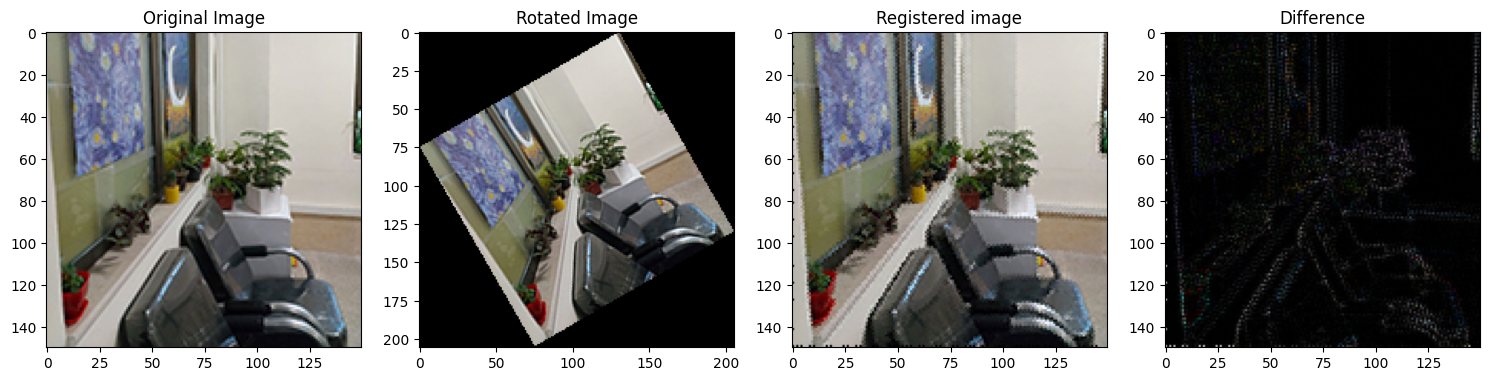

In [ ]:
import cv2
from matplotlib import pyplot as plt

image = np.array(image)
register_image = np.array(register_image)
difference = cv2.absdiff(image, register_image)

# Visualize the results
plt.figure(figsize=(15, 20))


plt.subplot(141)
plt.imshow(image)
plt.title('Original Image')


plt.subplot(142)
plt.imshow(rotated_image)
plt.title('Rotated Image')

plt.subplot(143)
plt.imshow(register_image)
plt.title('Registered image')

plt.subplot(144)
plt.imshow(difference)
plt.title('Difference')


plt.tight_layout()
plt.show()